In [60]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [62]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [63]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df = merge_csv(train_df_raw, train_calendar_df_raw)
test_df = merge_csv(test_df_raw, test_calendar_df_raw) 
train_df.head()

{'precipitation', 'snow', 'winter_school_holidays', 'mini_shutdown', 'school_holidays', 'blackout', 'holiday', 'shutdown', 'holiday_name', 'warehouse', 'date', 'mov_change', 'shops_closed', 'frankfurt_shutdown'}
No differences found in column: precipitation
No differences found in column: snow
No differences found in column: winter_school_holidays
No differences found in column: mini_shutdown
No differences found in column: school_holidays
No differences found in column: blackout
No differences found in column: holiday
No differences found in column: shutdown
No differences found in column: holiday_name
No differences found in column: mov_change
No differences found in column: shops_closed
No differences found in column: frankfurt_shutdown

Success. All values match across the datasets, datasets merged.
{'winter_school_holidays', 'school_holidays', 'holiday', 'warehouse', 'holiday_name', 'date', 'shops_closed'}
No differences found in column: winter_school_holidays
No differences found

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05,0
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06,0
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07,0
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08,0
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09,0


### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [64]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['warehouse_limited', 'precipitation', 'mini_shutdown', 'snow', 'blackout', 'shutdown', 'user_activity_1', 'mov_change', 'user_activity_2', 'frankfurt_shutdown']


In [65]:
train_df = train_df.drop(columns=unavailable_features)
train_df = train_df.drop(columns=['id', 'holiday_name']) # redundant
test_df = test_df.drop(columns=['id', 'holiday_name']) # redundant

In [66]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [67]:
print(train_df.head())
print(test_df.head())
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

  warehouse       date  orders  holiday  shops_closed  winter_school_holidays  \
0  Prague_1 2020-12-05  6895.0        0             0                       0   
1  Prague_1 2020-12-06  6584.0        0             0                       0   
2  Prague_1 2020-12-07  7030.0        0             0                       0   
3  Prague_1 2020-12-08  6550.0        0             0                       0   
4  Prague_1 2020-12-09  6910.0        0             0                       0   

   school_holidays  
0                0  
1                0  
2                0  
3                0  
4                0  
  warehouse       date  holiday  shops_closed  winter_school_holidays  \
0  Prague_1 2024-03-16        0             0                       0   
1  Prague_1 2024-03-17        0             0                       0   
2  Prague_1 2024-03-18        0             0                       0   
3  Prague_1 2024-03-19        0             0                       0   
4  Prague_1 2024-03-20

Add time series feature (day, monts...) here

In [68]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [69]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")


Train max date: 2024-05-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: -60 days +00:00:00


In [70]:
train_df.head()

,warehouse,date,orders,holiday,shops_closed,winter_school_holidays,school_holidays
0,Prague_1,2020-12-05,6895.0,0,0,0,0
1,Prague_1,2020-12-06,6584.0,0,0,0,0
2,Prague_1,2020-12-07,7030.0,0,0,0,0
3,Prague_1,2020-12-08,6550.0,0,0,0,0
4,Prague_1,2020-12-09,6910.0,0,0,0,0


In [71]:
train_df.describe()

,date,orders,holiday,shops_closed,winter_school_holidays,school_holidays
count,7737,7340.000000,7737.000000,7737.000000,7737.000000,7737.000000
mean,2022-09-27 08:38:31.593640704,5535.443869,0.029340,0.011374,0.029469,0.010340
min,2020-12-05 00:00:00,790.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-12-10 00:00:00,4434.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-10-08 00:00:00,5370.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-07-27 00:00:00,7009.250000,0.000000,0.000000,0.000000,0.000000
max,2024-05-15 00:00:00,18139.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,2182.680279,0.168767,0.106047,0.169127,0.101165


In [72]:
# merge school_holiday and winter_schoolholiday into a single feature
train_df['school_holiday'] = train_df['school_holidays'] | train_df['winter_school_holidays']
train_df = train_df.drop(columns=['school_holidays', 'winter_school_holidays'])

In [73]:
def process_date(df):
    df.index = df.pop('date')
    df["quarter"] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    time_features = ['quarter', 'year', 'month', 'day', 'day_of_year', 'day_of_week']
    return df, time_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [74]:
train_df, time_features=process_date(train_df)

train_df.head()

,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,4,2020,12,5,340,5,1
2020-12-06,Prague_1,6584.0,0,0,0,4,2020,12,6,341,6,1
2020-12-07,Prague_1,7030.0,0,0,0,4,2020,12,7,342,0,0
2020-12-08,Prague_1,6550.0,0,0,0,4,2020,12,8,343,1,0
2020-12-09,Prague_1,6910.0,0,0,0,4,2020,12,9,344,2,0


### Plot

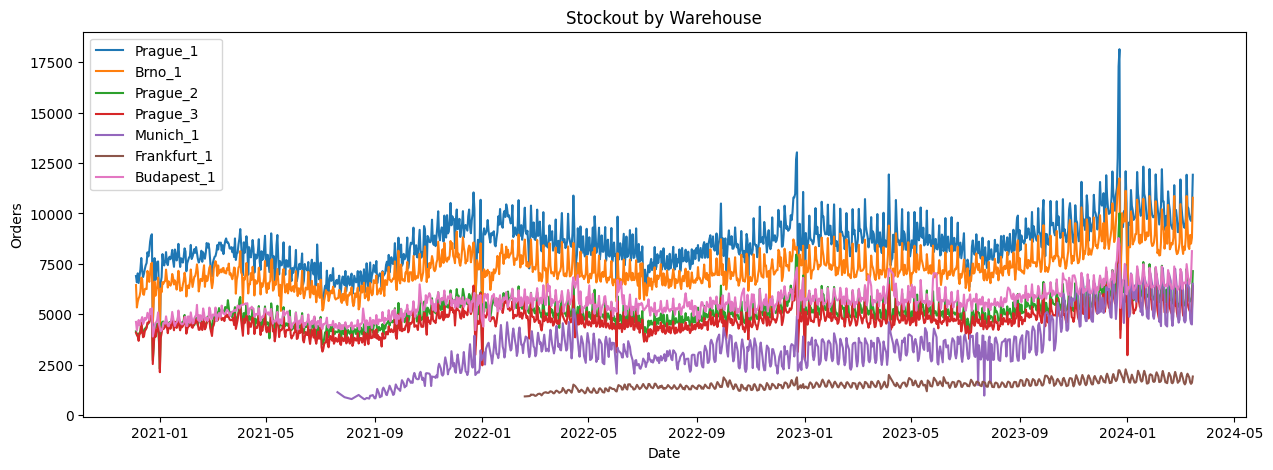

In [75]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [76]:
train_df['orders'].describe()

count     7340.000000
mean      5535.443869
std       2182.680279
min        790.000000
25%       4434.000000
50%       5370.000000
75%       7009.250000
max      18139.000000
Name: orders, dtype: float64

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

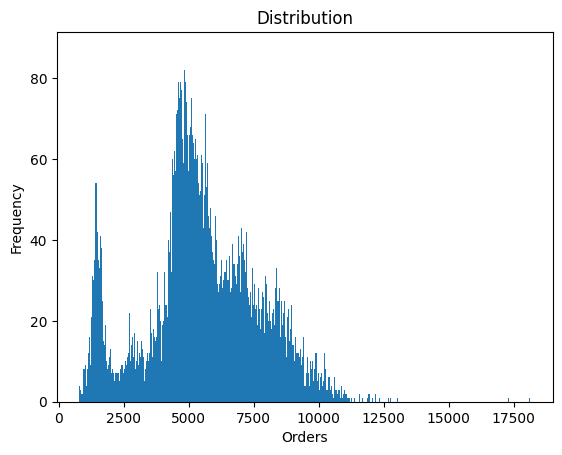

In [77]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

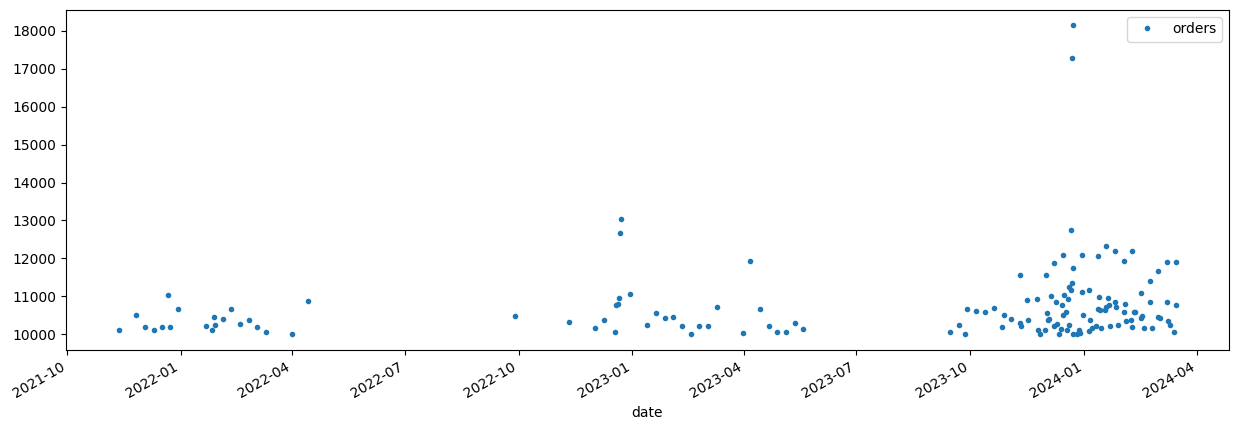

In [78]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

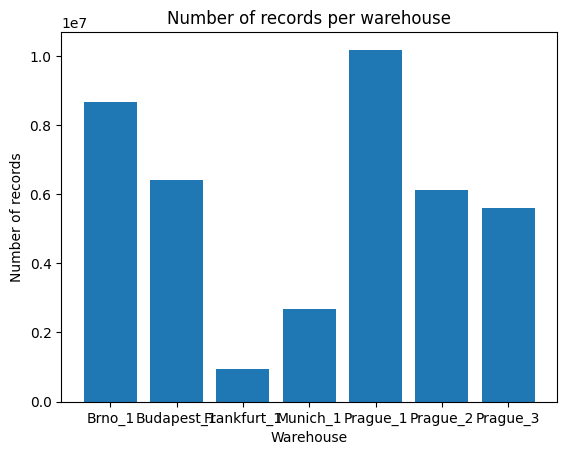

In [79]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

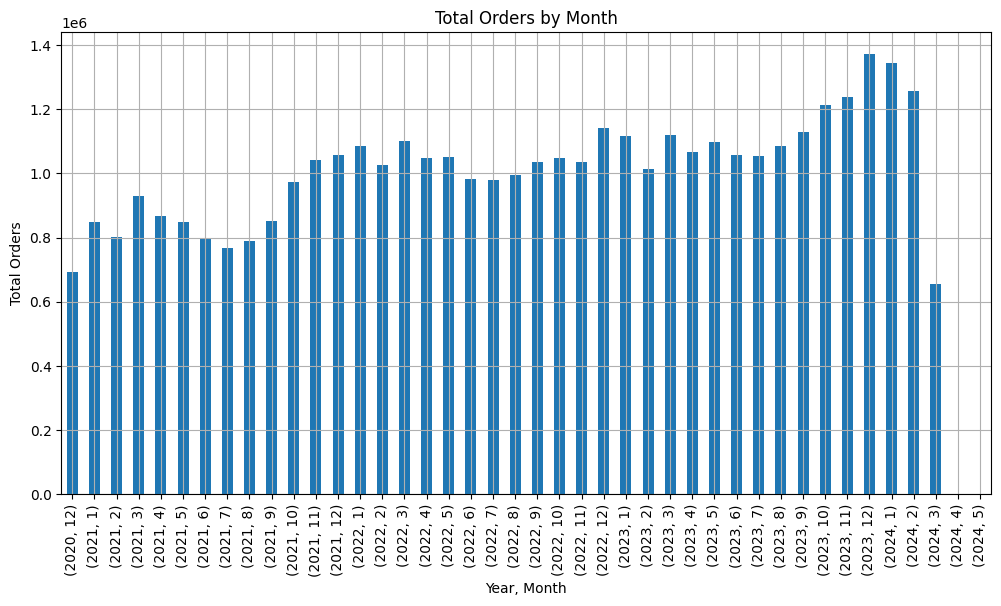

In [80]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

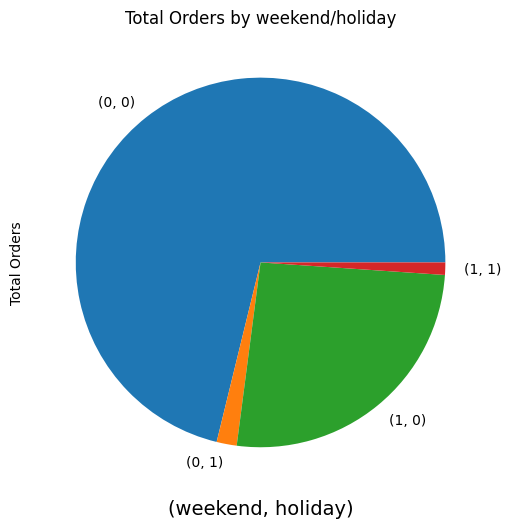

In [81]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [82]:
train_df_corr = train_df.drop(columns=['warehouse']).corr()

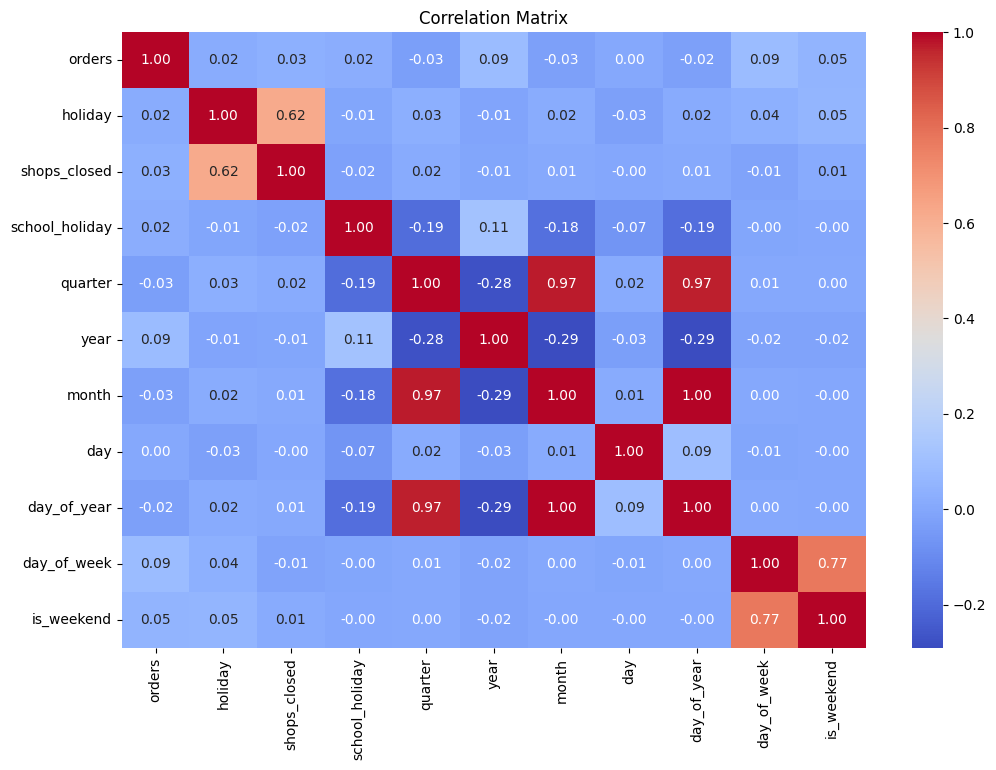

orders            1.000000
day_of_week       0.086522
year              0.085920
is_weekend        0.046594
shops_closed      0.034824
school_holiday    0.023044
holiday           0.018006
day               0.002689
day_of_year      -0.024332
month            -0.025271
quarter          -0.029323
Name: orders, dtype: float64


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Remove Outliers

In [84]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 5


,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,
2022-12-22,Prague_1,12661.0,0,0,0,4,2022,12,22,356,3,0
2022-12-23,Prague_1,13028.0,0,0,0,4,2022,12,23,357,4,0
2023-12-21,Prague_1,12744.0,0,0,0,4,2023,12,21,355,3,0
2023-12-22,Prague_1,17282.0,0,0,0,4,2023,12,22,356,4,0
2023-12-23,Prague_1,18139.0,0,0,0,4,2023,12,23,357,5,1


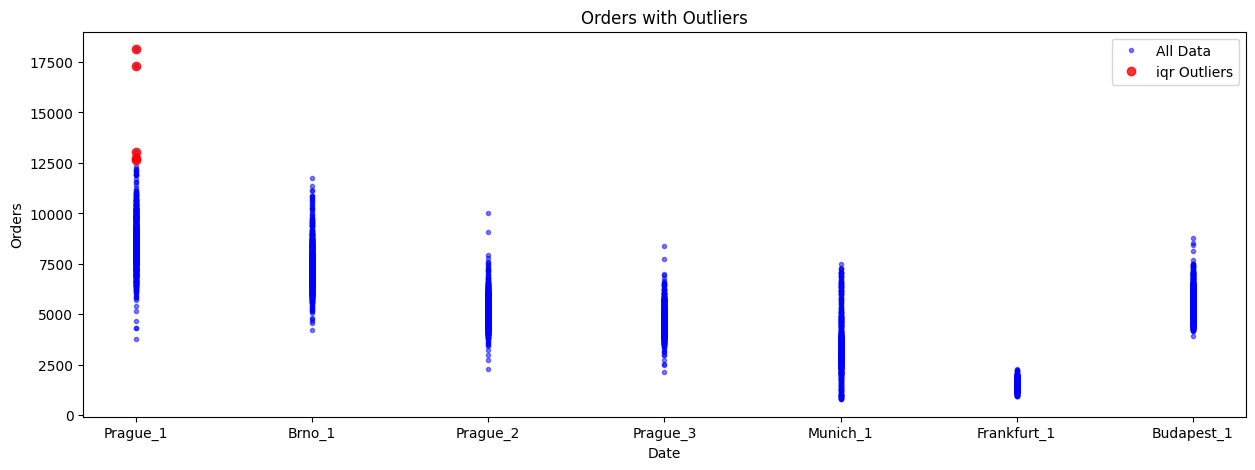

In [85]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [86]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# do not drop outliers but fix their values to be average
train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()

#### Time Series Cross Validation



In [87]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=398, gap=1) # gap - 24house between train gata end - test data start
cross_val_train_df = train_df.sort_index()

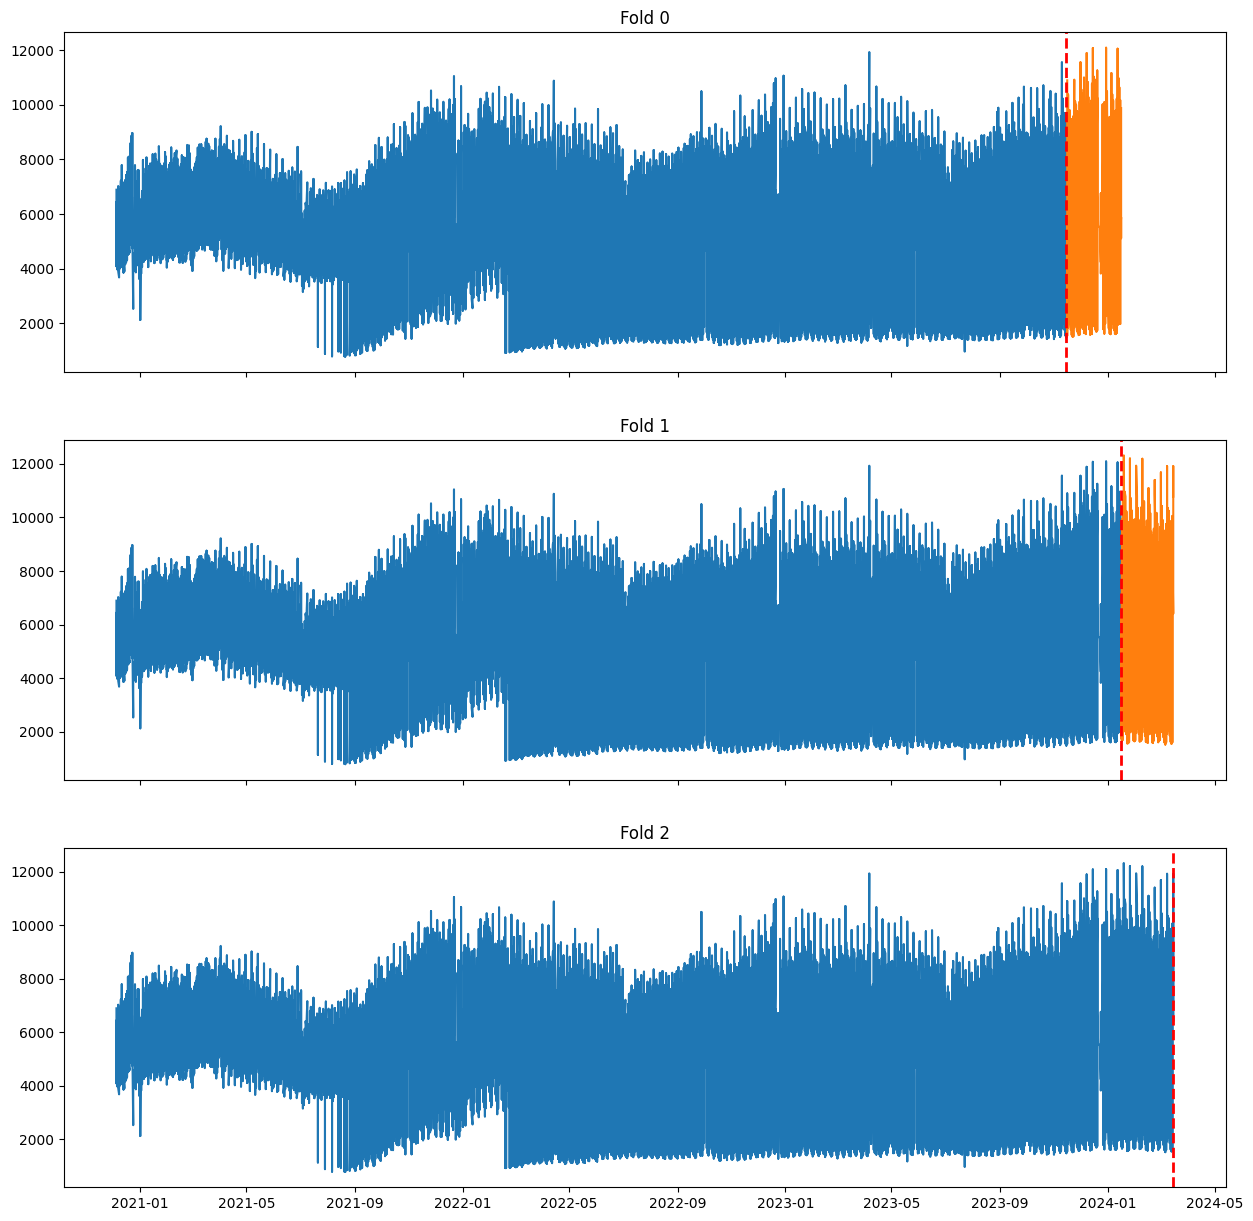

In [88]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(cross_val_train_df):
    train = cross_val_train_df.iloc[train_idx]
    test = cross_val_train_df.iloc[test_idx]
    
    ax[fold].plot(train.index, train['orders'], label='Train')
    ax[fold].plot(test.index, test['orders'], label='Test')
    ax[fold].set_title(f"Fold {fold}")
    ax[fold].axvline(train.index[-1], color='r', linestyle='--', lw=2)
    
    fold += 1

plt.show()

#### Forecasting Horizon

In [89]:
train_df.head()

,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,4,2020,12,5,340,5,1
2020-12-06,Prague_1,6584.0,0,0,0,4,2020,12,6,341,6,1
2020-12-07,Prague_1,7030.0,0,0,0,4,2020,12,7,342,0,0
2020-12-08,Prague_1,6550.0,0,0,0,4,2020,12,8,343,1,0
2020-12-09,Prague_1,6910.0,0,0,0,4,2020,12,9,344,2,0


### Temporal features

In [90]:
train_df.sort_index(inplace=True)

In [91]:
train_df.head()

,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend
date,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,4,2020,12,5,340,5,1
2020-12-05,Prague_2,4154.0,0,0,0,4,2020,12,5,340,5,1
2020-12-05,Budapest_1,4623.0,0,0,0,4,2020,12,5,340,5,1
2020-12-05,Prague_3,4091.0,0,0,0,4,2020,12,5,340,5,1
2020-12-05,Brno_1,6447.0,0,0,0,4,2020,12,5,340,5,1


In [92]:
LAG_DAYS = [98, 196, 364]
ROLLING_WINDOW = [98, 364]

In [93]:
# Create lag features
def create_lag_features(df, col, lag_days):
    lag_features = []
    # create lag features for each warehouse, stop at the last dataset day even if the lag is not complete
    for lag in lag_days:
        df[f'{col}_lag_{lag}'] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(f'{col}_lag_{lag}')
    return df, lag_features


# Create rolling statistics
def create_rolling_features(df, col, windows):
    window_features = []
    # create rolling features for each warehouse, stop at the last dataset day even if the lag is not complete
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'{col}_rolling_std_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        window_features.extend([f'{col}_rolling_mean_{window}', f'{col}_rolling_std_{window}'])
    return df, window_features


In [94]:
# Apply the functions
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Combine the features for easier visualization
numerical_features = lag_features + window_features
categorical_features=['warehouse']

print(numerical_features)

train_df.head()

['orders', 'orders_lag_98', 'orders_lag_196', 'orders_lag_364', 'orders_rolling_mean_98', 'orders_rolling_std_98', 'orders_rolling_mean_364', 'orders_rolling_std_364']


,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN
2020-12-05,Prague_2,4154.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN
2020-12-05,Budapest_1,4623.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN
2020-12-05,Prague_3,4091.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN
2020-12-05,Brno_1,6447.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN


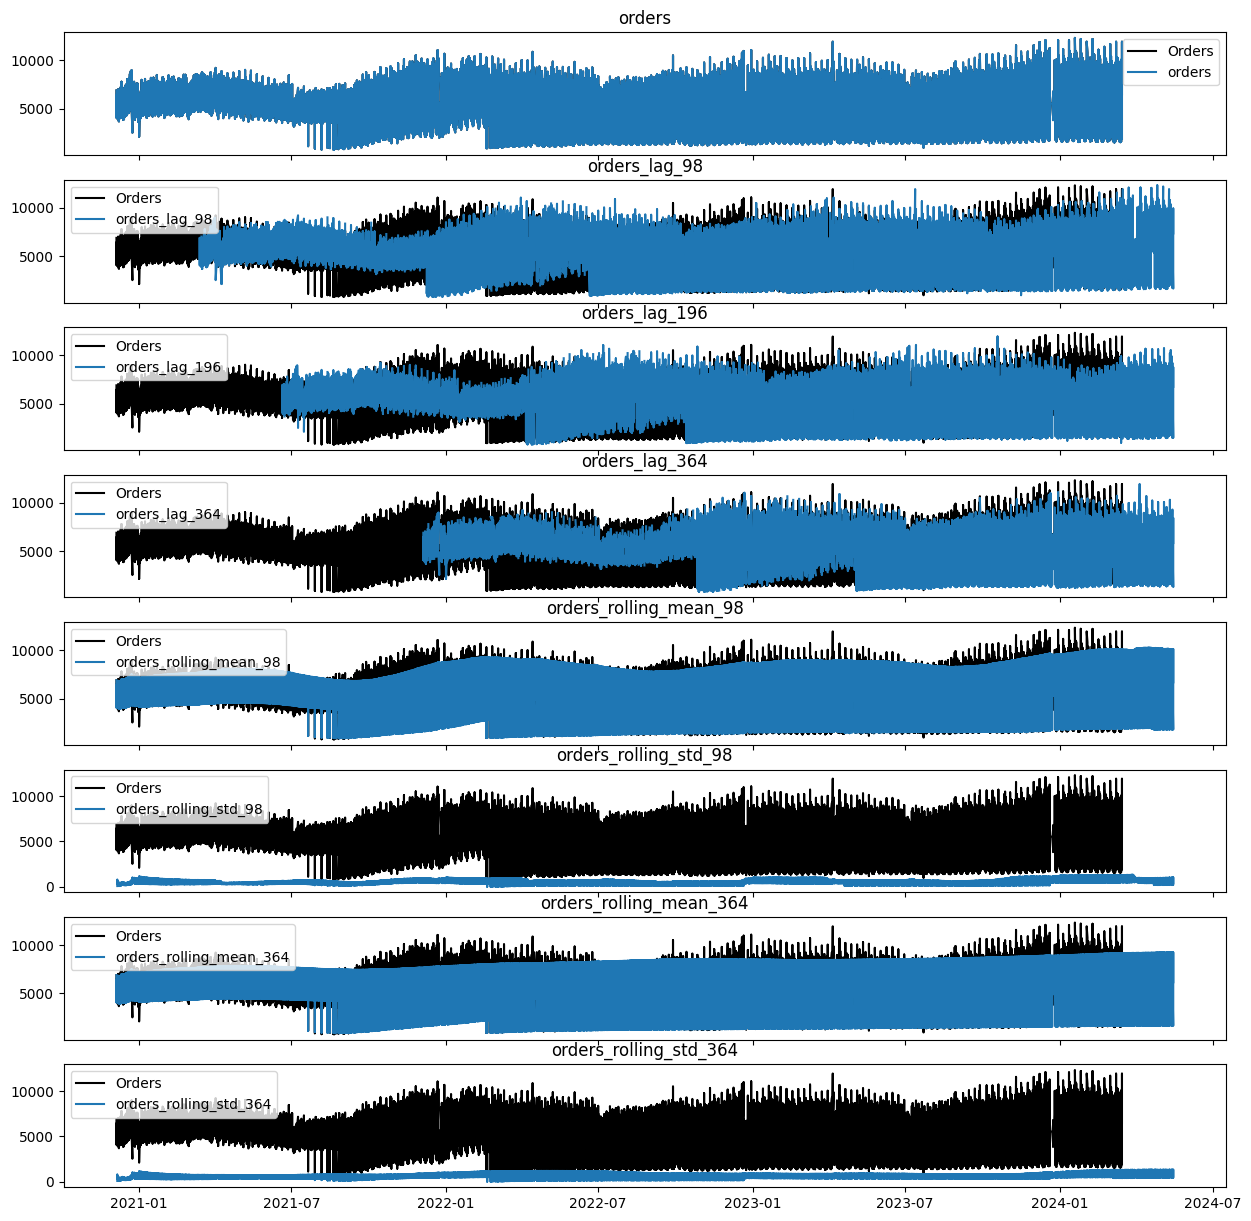

In [95]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df.index, train_df['orders'], label='Orders', color='black')
    ax[i].plot(train_df.index, train_df[feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


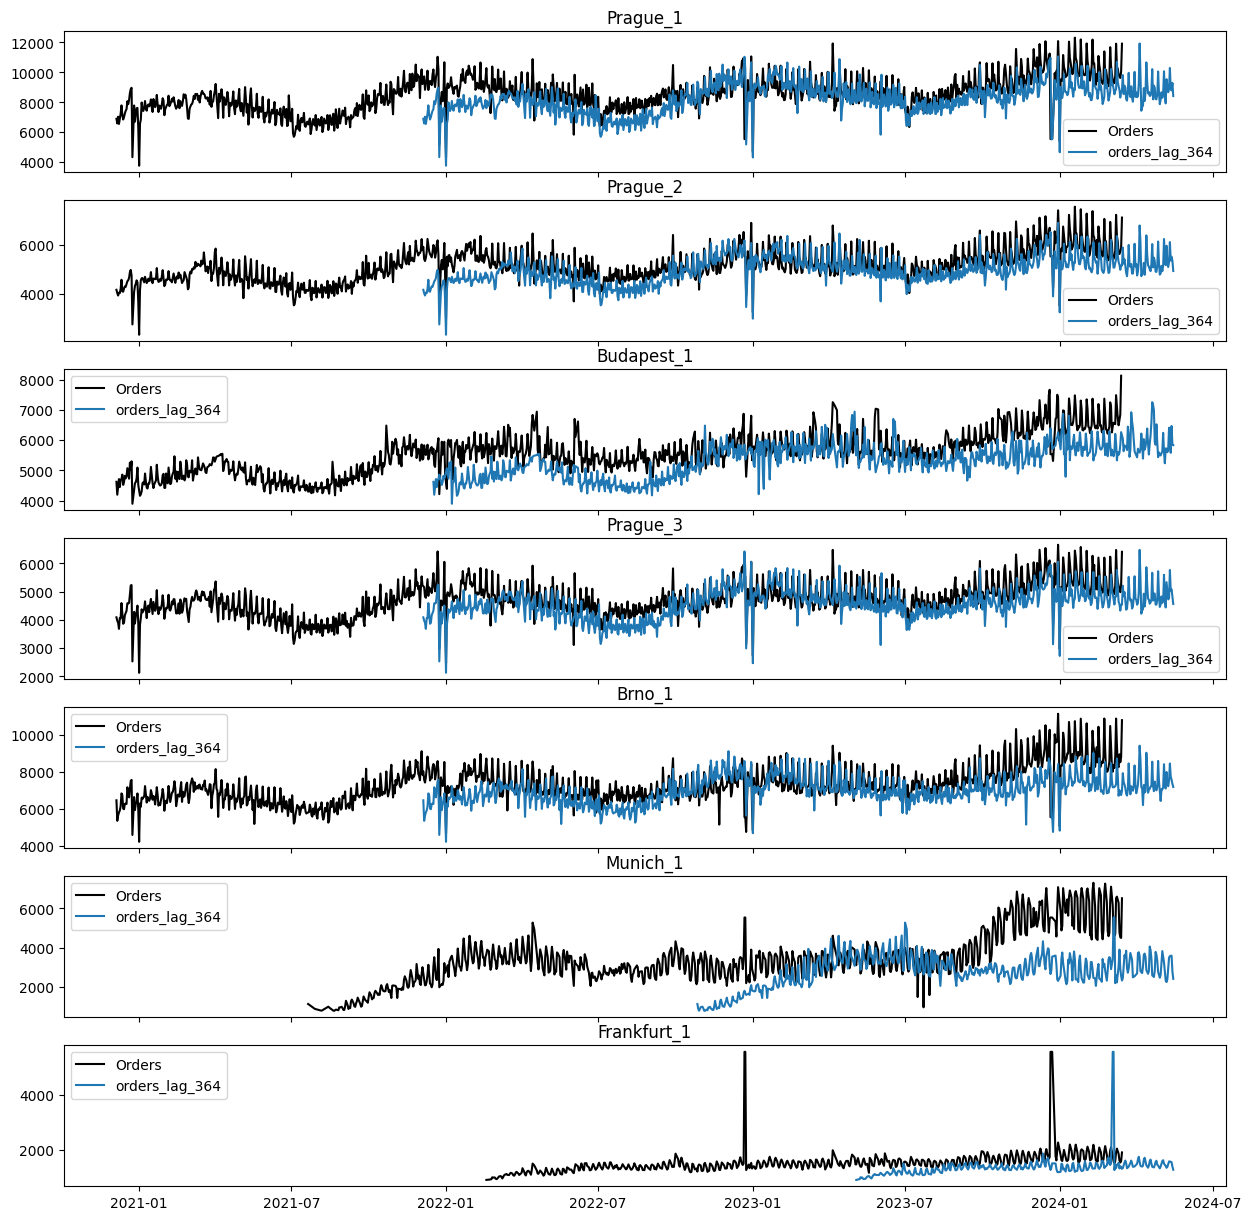

In [96]:
# make plots for every warehouse with with lag 98 feature
feature = 'orders_lag_364'

fig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)
for i, warehouse in enumerate(train_df['warehouse'].unique()):
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')
    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)
    ax[i].set_title(warehouse)
    ax[i].legend()
plt.show()

In [97]:
# divide dataset back into train and test datasets according to the dates from the original datasets:
test_date_range = (test_df_raw.date.min(), test_df_raw.date.max())
train_date_range = (train_df_raw.date.min(), train_df_raw.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
#test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

In [98]:
test_df.head()

,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,
2024-03-16,Frankfurt_1,NaN,0,0,0,1,2024,3,16,76,5,1,1777.0,1409.0,1354.0,1905.013728,678.366221,1649.499536,402.229296
2024-03-16,Munich_1,NaN,0,0,0,1,2024,3,16,76,5,1,6710.0,2891.0,2448.0,5684.158058,884.763406,4126.981630,1304.648225
2024-03-16,Prague_3,NaN,0,0,0,1,2024,3,16,76,5,1,6480.0,5085.0,5207.0,5484.962182,560.099532,5047.033971,549.088483
2024-03-16,Prague_2,NaN,0,0,0,1,2024,3,16,76,5,1,7135.0,5496.0,5901.0,6112.271460,628.716150,5541.193751,644.926369
2024-03-16,Budapest_1,NaN,0,0,0,1,2024,3,16,76,5,1,6769.0,5373.0,6047.0,6647.859089,475.779268,6119.761244,552.134147


In [99]:
test_df.to_csv('data/test_proc.csv')

### OH encoding of categorical features

In [100]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[categorical_features])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    
# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

if 'holiday_name_nan' in encoded_df.columns:
    encoded_df = encoded_df.drop(columns=['holiday_name_nan'])
    encoded_feature_names = encoded_feature_names.tolist()
    encoded_feature_names.remove('holiday_name_nan')
print(encoded_feature_names)    

encoded_df.index = train_df.index

# Concatenate the encoded features with the original DataFrame
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

['warehouse_Brno_1' 'warehouse_Budapest_1' 'warehouse_Frankfurt_1'
 'warehouse_Munich_1' 'warehouse_Prague_1' 'warehouse_Prague_2'
 'warehouse_Prague_3']


c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical.joblib']

In [101]:
train_df= train_df.drop(columns=categorical_features)

In [102]:
train_df.head()

,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,6895.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2020-12-05,4154.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-12-05,4623.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4091.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-05,6447.0,0,0,0,4,2020,12,5,340,5,1,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0


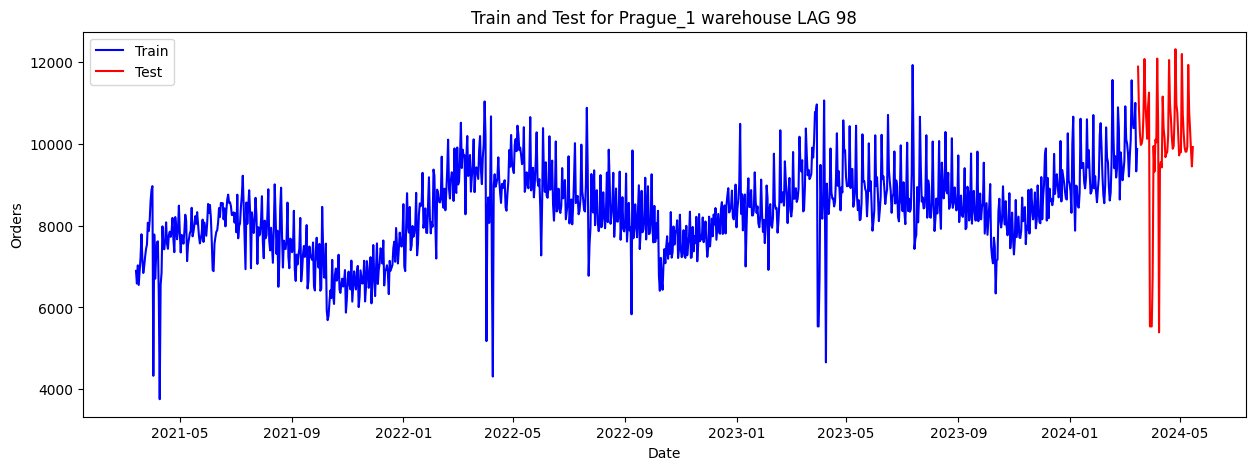

In [103]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse_Prague_1'] == 1]
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax['orders_lag_98'], label='Train', color='blue')
plt.plot(datax_test.index, datax_test['orders_lag_98'], label='Test', color='red')




plt.title('Train and Test for Prague_1 warehouse LAG 98')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

### Min-Max scale numerical features

In [104]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
num_scaler = MinMaxScaler()
date_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scaler on the numerical columns
train_df[numerical_features] = num_scaler.fit_transform(train_df[numerical_features])
train_df[time_features] = date_scaler.fit_transform(train_df[time_features])
train_df['orders'] = target_scaler.fit_transform(train_df['orders'])

# Save the scaler
joblib.dump(num_scaler, 'scaler_minmax_numerical.joblib')
joblib.dump(date_scaler, 'scaler_minmax_date.joblib')
joblib.dump(target_scaler, 'scaler_minmax_target.joblib')

['scaler_minmax_date.joblib']

In [105]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'num_features': numerical_features,
    'cat_features': categorical_features,
    'time_features': time_features,
    'targer_feature': 'orders'
}

joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

In [106]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 25)
Test data: (397, 19)


In [107]:
print(train_df.isna().sum())  # Check for Nas

orders                        0
holiday                       0
shops_closed                  0
school_holiday                0
quarter                       0
year                          0
month                         0
day                           0
day_of_year                   0
day_of_week                   0
is_weekend                    0
orders_lag_98               686
orders_lag_196             1372
orders_lag_364             2548
orders_rolling_mean_98        0
orders_rolling_std_98         7
orders_rolling_mean_364       0
orders_rolling_std_364        7
warehouse_Brno_1              0
warehouse_Budapest_1          0
warehouse_Frankfurt_1         0
warehouse_Munich_1            0
warehouse_Prague_1            0
warehouse_Prague_2            0
warehouse_Prague_3            0
dtype: int64


In [108]:
"""drop nan values of these columns 
orders_lag_98                                                                
orders_lag_196                                                             
orders_lag_364                                                              
orders_rolling_mean_98                                                         
orders_rolling_std_98                                                          
orders_rolling_mean_364                                                        
orders_rolling_std_364     
"""
train_df = train_df.dropna(subset=['orders_lag_98', 'orders_lag_196', 'orders_lag_364', 'orders_rolling_mean_98', 'orders_rolling_std_98', 'orders_rolling_mean_364', 'orders_rolling_std_364'])
                                                    

In [109]:
train_df.describe()

,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
count,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000
mean,0.452137,0.028172,0.011686,0.042571,0.476349,0.666684,0.481446,0.488230,0.479521,0.488766,0.267112,0.449411,0.431589,0.453897,0.546189,0.421199,0.578459,0.483339,0.172997,0.164858,0.055301,0.087855,0.172997,0.172997,0.172997
std,0.176886,0.165481,0.107480,0.201909,0.390282,0.173171,0.332971,0.292026,0.306758,0.326792,0.442497,0.179520,0.175217,0.193591,0.211122,0.176573,0.226473,0.167179,0.378284,0.371091,0.228590,0.283113,0.378284,0.378284,0.378284
min,0.015613,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016155,0.016155,0.000000,0.066857,0.090701,0.060853,0.250435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351115,0.000000,0.000000,0.000000,0.000000,0.500000,0.181818,0.233333,0.186301,0.166667,0.000000,0.350924,0.334410,0.354818,0.431039,0.303230,0.457896,0.362610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.424538,0.000000,0.000000,0.000000,0.333333,0.750000,0.454545,0.466667,0.473973,0.500000,0.000000,0.425906,0.413481,0.433139,0.508145,0.385606,0.532586,0.444232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.568133,0.000000,0.000000,0.000000,1.000000,0.750000,0.818182,0.733333,0.753425,0.833333,1.000000,0.575749,0.556835,0.591436,0.707082,0.510285,0.756933,0.600991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997260,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    3963
1 days     825
2 days       3
Name: count, dtype: int64

### Create Time Series 

In [111]:
train_df.head()

,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-05,0.741261,0,0,0,1.0,0.25,1.0,0.133333,0.926027,1.0,1,0.550530,0.553761,0.594161,0.803749,0.735620,0.820886,0.700244,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-12-05,0.381993,0,0,0,1.0,0.25,1.0,0.133333,0.926027,1.0,1,0.276432,0.277150,0.321265,0.396085,0.380783,0.413130,0.377943,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-05,0.625987,0,0,0,1.0,0.25,1.0,0.133333,0.926027,1.0,1,0.462395,0.474690,0.550560,0.685922,0.534772,0.696343,0.531285,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-05,0.445485,0,0,0,1.0,0.25,1.0,0.133333,0.926027,1.0,1,0.314486,0.325346,0.327397,0.449475,0.403919,0.454420,0.395888,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-12-06,0.587041,0,0,0,1.0,0.25,1.0,0.166667,0.928767,0.0,0,0.468318,0.500180,0.442628,0.687643,0.527075,0.697080,0.529840,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
X_train = train_df.drop(columns=['orders'])
y_train = train_df['orders']

In [131]:
def prepare_data_for_lstm(df, target_col_index, n_timesteps):
    X, y = [], []
    for i in range(n_timesteps, len(df)):
        X.append(df.iloc[i-n_timesteps:i, :].values)
        y.append(df.iloc[i, target_col_index])
    return np.array(X), np.array(y)

# Define the number of timesteps (sequence length)
n_timesteps = 98

# Prepare training sequences
X, y = prepare_data_for_lstm(train_df, train_df.columns.get_loc('orders'), n_timesteps)

print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}") 

X shape: (4694, 98, 25)
y shape: (4694,)


In [138]:
def create_datset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 28
X, y = create_datset(X_train, y_train, time_steps)

print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}") 

X shape: (4764, 28, 24)
y shape: (4764,)


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

train_gen = TimeseriesGenerator(data=train_df, targets=train_df["orders"], length=28, shuffle=False, batch_size=32)

### Data Loading

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

### Compile and Fit the model

In [141]:
checkpointing = tf.keras.callbacks.ModelCheckpoint('model_lstm.h5', save_best_only=True)

In [146]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpointing])

Epoch 1/5
268/268 [==============================] - 68s 247ms/step - loss: 0.0379 - val_loss: 0.0489
Epoch 2/5
268/268 [==============================] - 67s 249ms/step - loss: 0.0308 - val_loss: 0.0541
Epoch 3/5
268/268 [==============================] - 64s 239ms/step - loss: 0.0295 - val_loss: 0.0498
Epoch 4/5
268/268 [==============================] - 65s 243ms/step - loss: 0.0279 - val_loss: 0.0481
Epoch 5/5
268/268 [==============================] - 64s 241ms/step - loss: 0.0273 - val_loss: 0.0550


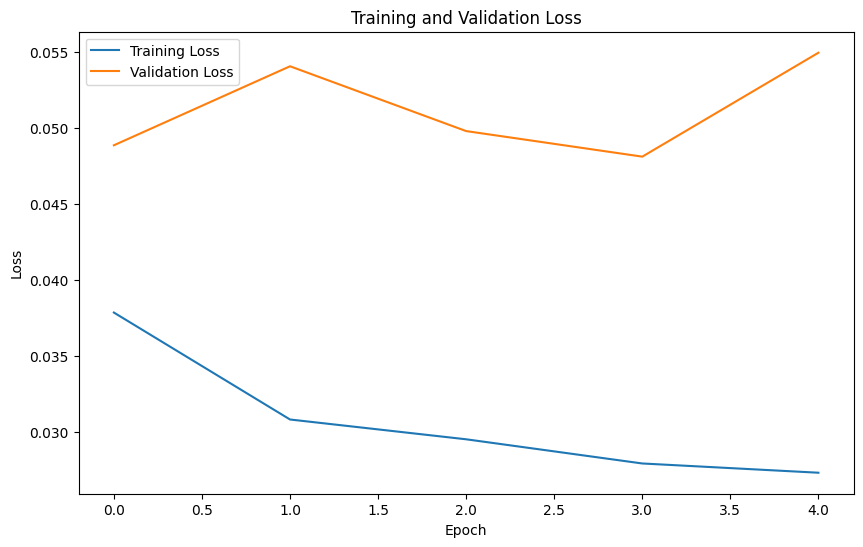

In [147]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [148]:
# Save the model
model.save('model_lstm.h5')

## Inference

In [149]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test_proc.csv")

In [150]:
loaded_oh_encoder = joblib.load('scaler_onehot_categorical.joblib')
loaded_num_scaler = joblib.load('scaler_minmax_numerical.joblib')
loaded_date_scaler = joblib.load('scaler_minmax_date.joblib')
loaded_target_scaler = joblib.load('scaler_minmax_target.joblib')

In [151]:
dataframe.head()

,date,warehouse,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364
0,2024-03-16,Frankfurt_1,NaN,0,0,0,1,2024,3,16,76,5,1,1777.0,1409.0,1354.0,1905.013728,678.366221,1649.499536,402.229296
1,2024-03-16,Munich_1,NaN,0,0,0,1,2024,3,16,76,5,1,6710.0,2891.0,2448.0,5684.158058,884.763406,4126.981630,1304.648225
2,2024-03-16,Prague_3,NaN,0,0,0,1,2024,3,16,76,5,1,6480.0,5085.0,5207.0,5484.962182,560.099532,5047.033971,549.088483
3,2024-03-16,Prague_2,NaN,0,0,0,1,2024,3,16,76,5,1,7135.0,5496.0,5901.0,6112.271460,628.716150,5541.193751,644.926369
4,2024-03-16,Budapest_1,NaN,0,0,0,1,2024,3,16,76,5,1,6769.0,5373.0,6047.0,6647.859089,475.779268,6119.761244,552.134147


In [152]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib')

num_features = scaler_config['num_features']
cat_features = scaler_config['cat_features']
time_features = scaler_config['time_features']
    
print(f"num_features: {num_features}")
print(f"cat_features: {cat_features}")
print(f"time_features: {time_features}")

num_features: ['orders', 'orders_lag_98', 'orders_lag_196', 'orders_lag_364', 'orders_rolling_mean_98', 'orders_rolling_std_98', 'orders_rolling_mean_364', 'orders_rolling_std_364']
cat_features: ['warehouse']
time_features: ['quarter', 'year', 'month', 'day', 'day_of_year', 'day_of_week']


In [153]:
from working import preprocess_data


processed_data = preprocess_data(dataframe, cat_features, num_features, time_features, loaded_oh_encoder, loaded_num_scaler, loaded_date_scaler)

In [154]:
processed_data.head()     

,orders,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
date,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-16,NaN,0,0,0,0.0,1.0,0.181818,0.5,0.205479,0.833333,1,0.088584,0.055556,0.054891,0.109412,0.525339,0.090623,0.307062,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-03-16,NaN,0,0,0,0.0,1.0,0.181818,0.5,0.205479,0.833333,1,0.531323,0.188566,0.161363,0.520832,0.685510,0.390180,0.998400,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2024-03-16,NaN,0,0,0,0.0,1.0,0.181818,0.5,0.205479,0.833333,1,0.510680,0.385478,0.429878,0.499146,0.433560,0.501425,0.419570,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-03-16,NaN,0,0,0,0.0,1.0,0.181818,0.5,0.205479,0.833333,1,0.569467,0.422366,0.497421,0.567438,0.486809,0.561175,0.492991,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-16,NaN,0,0,0,0.0,1.0,0.181818,0.5,0.205479,0.833333,1,0.536618,0.411327,0.511630,0.625746,0.368124,0.631131,0.421904,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [155]:
processed_data.shape

(397, 25)

In [156]:
# Compare the columns in the original and processed dataframes

X_columns = set(train_df.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("Both dataframes have the same columns.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

Both dataframes have the same columns.


In [162]:
processed_data = processed_data.fillna(0)
processed_data = processed_data.drop(columns=['orders'])

In [165]:
processed_data_X = []
time_steps = 28

for i in range(len(processed_data) - time_steps):
    v = processed_data.iloc[i:(i + time_steps)].to_numpy()
    processed_data_X.append(v)
processed_data_X = np.array(processed_data_X)

print(f"X shape: {processed_data_X.shape}") 

X shape: (369, 28, 24)


In [167]:
import tensorflow as tf

# Load the trained model and make predictions on processed data:
model = tf.keras.models.load_model('model_lstm.h5')

predictions = model.predict(processed_data_X)

12/12 [==============================] - 1s 38ms/step


In [179]:
predictions.shape  

(369, 8)

In [183]:
# Rescale the predictions to original scale:
predictions_rescaled = loaded_target_scaler.inverse_transform(predictions)
submission_df_rescaled = pd.DataFrame({'orders': predictions_rescaled.flatten()})
submission_df_rescaled.to_csv('submission_rescaled.csv', index=False)
submission_df_rescaled.head()

,orders
0,4870.957520
1,4733.970215
2,4733.970215
3,4427.075195
4,4151.462402


In [184]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df_rescaled['date'] = dataframe['date']
submission_df_rescaled['warehouse'] = dataframe['warehouse']
submission_df_rescaled.head()

,orders,date,warehouse
0,4870.957520,2024-03-16,Frankfurt_1
1,4733.970215,2024-03-16,Munich_1
2,4733.970215,2024-03-16,Prague_3
3,4427.075195,2024-03-16,Prague_2
4,4151.462402,2024-03-16,Budapest_1


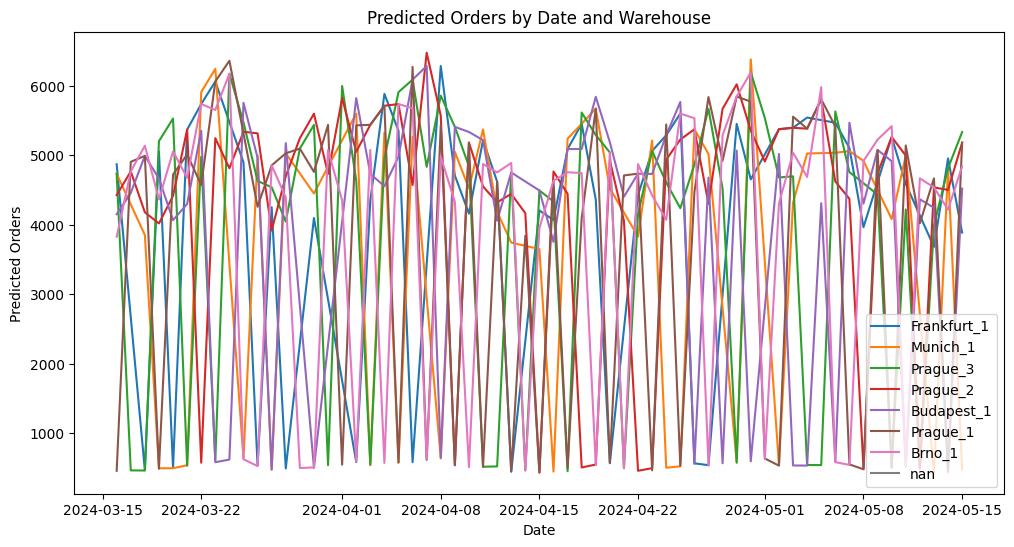

In [185]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df_rescaled['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

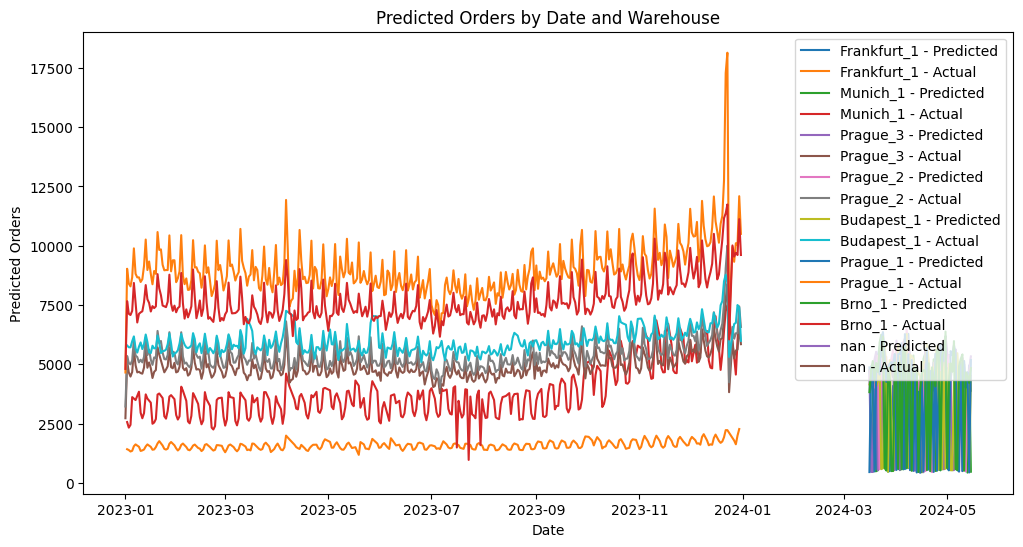

In [186]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


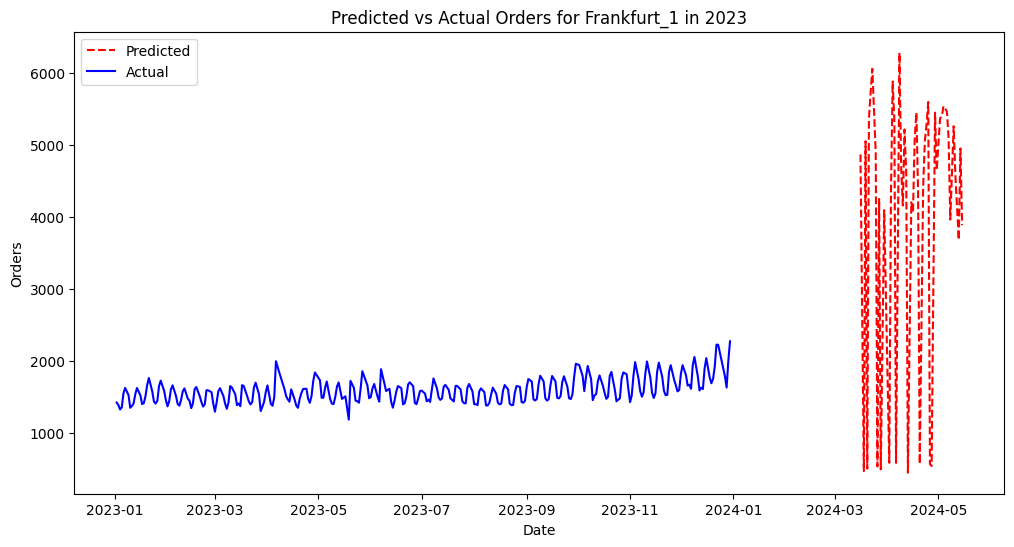

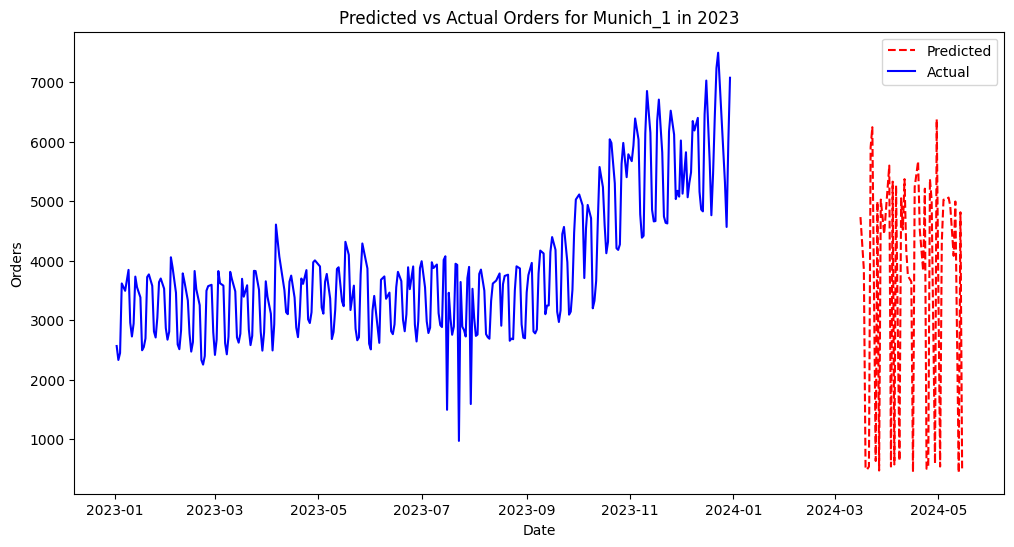

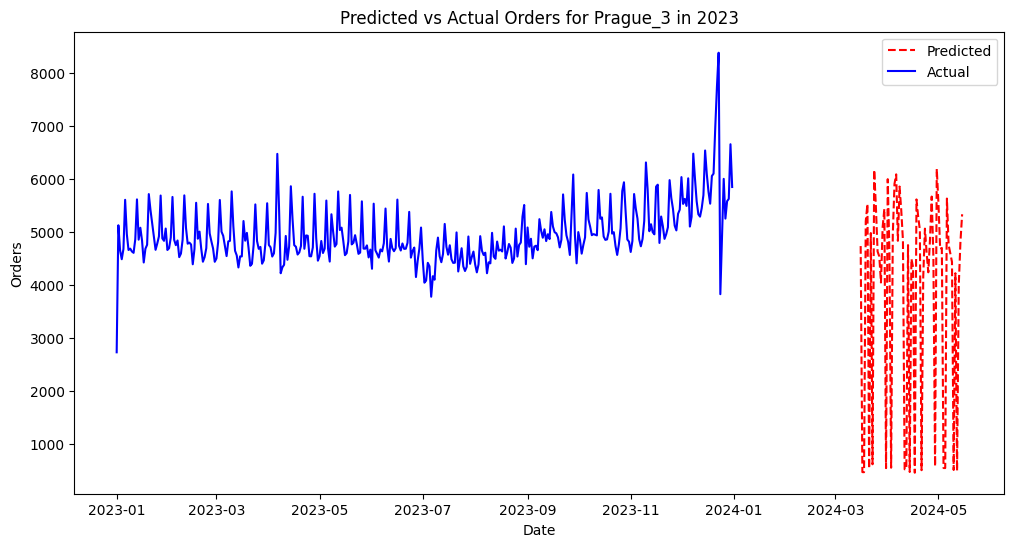

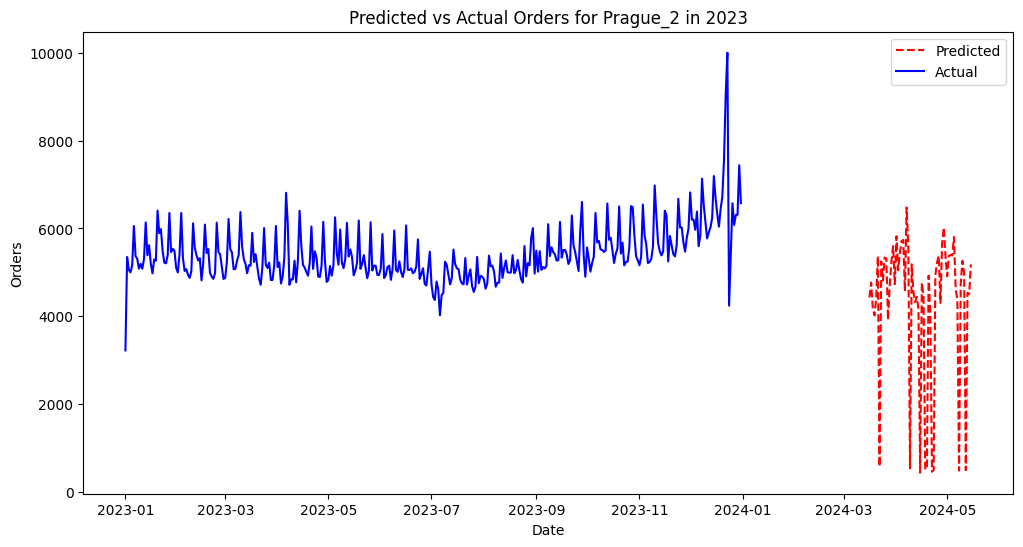

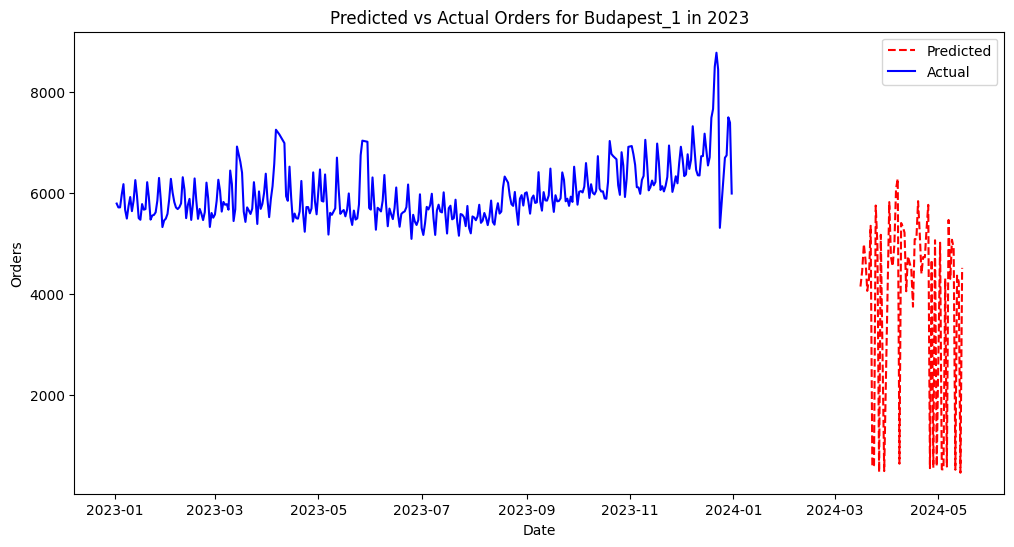

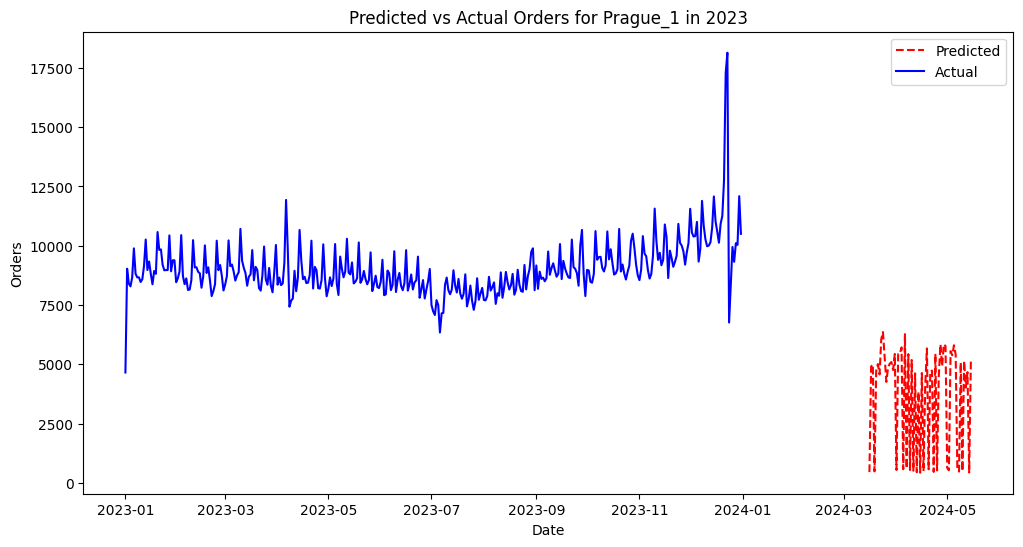

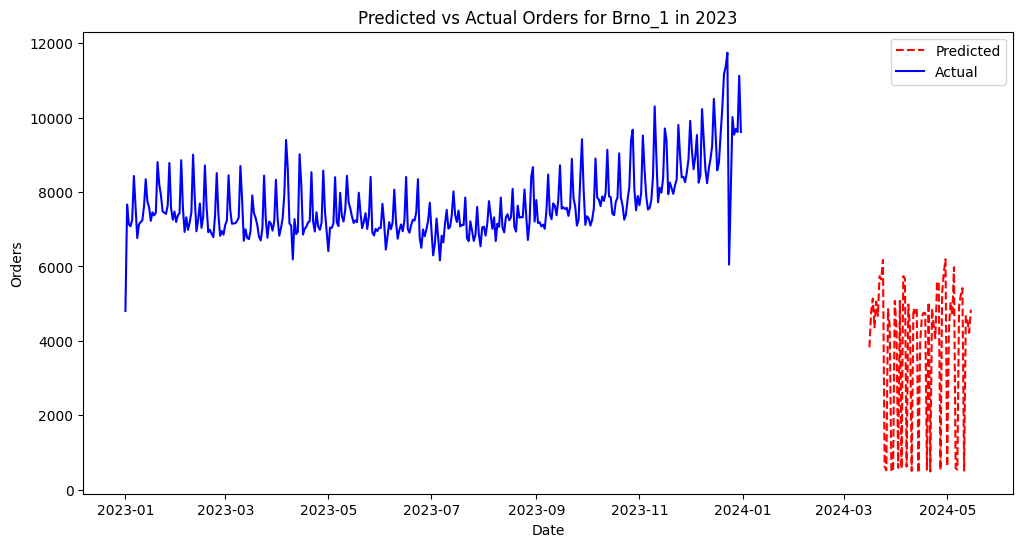

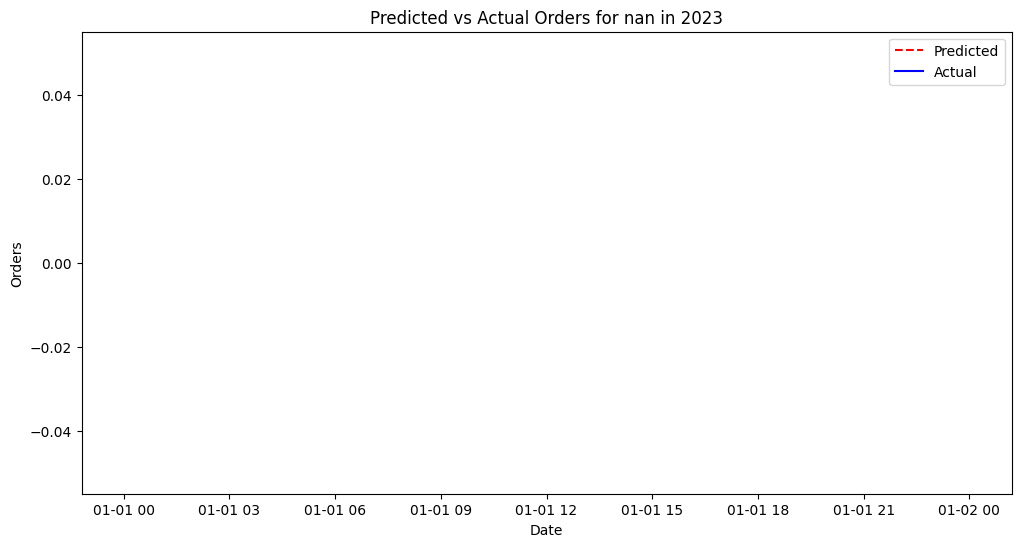

In [187]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
